In [1]:
import pyforest
import sys
sys.path.append('/Users/jayceepang/msse/ATOM_CODE/UTILS/')
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix

import matplotlib.lines as mlines
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem

import os
import shutil
import scipy as sp
from sklearn.metrics import pairwise_distances


In [2]:
k=7
# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis - train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score


In [11]:
og_neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
new_neks=['NEK1', 'NEK11', 'NEK2', 'NEK3', 'NEK4', 'NEK5',
       'NEK6', 'NEK9']
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding',
       'NEK9_binding', 'NEK9_inhibition']
og_datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
holdout_datapath = '/Users/jayceepang/msse/ATOM_CODE/datasets/holdout_data/featurized/'
neks = ['NEK2_binding','NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition']
feat_types = ['MOE','MFP']
samplings = ['none_scaled', 'UNDER', 'SMOTE']


In [12]:
nek_names = [] 
all_feats = [] 
sampling_types = [] 
test_dists = []
holdout2_dists=[]
train_holdout_dists=[]

for nek in neks: 
    for samp in samplings: 
        full_df = pd.read_csv(f'{df_path}{nek}_{feat}_{samp}.csv') 
        train_df = full_df[full_df['subset'] == 'train'].drop(columns=remove_cols)
        test_df = full_df[full_df['subset'] == 'test'].drop(columns=remove_cols)
        test_dist = calc_AD_kmean_dist(train_df, test_df, k)
        # train_dist = calc_AD_kmean_dist(train_df, train_df, k)
 

        for new_nek in new_neks: 
            # short_nek = new_nek[:4]
            print(new_nek)
            if nek[:4] == new_nek:
                new_nek_df = pd.read_csv(f'{holdout_datapath}{new_nek}_MFP_none_unscaled.csv')
    
                holdout_df = new_nek_df[new_nek_df['subset'] == 'test'].drop(columns=remove_cols)
                holdout_dist = calc_AD_kmean_dist(train_df, holdout_df, k)
            if samp == 'none_scaled': 
                adjusted_samp = 'Orig'
            else:
                adjusted_samp = samp
        
        test_dists.append(test_dist) 
        holdout2_dists.append(holdout_dist)
        nek_names.append(f'{nek}')
        all_feats.append(feat) 
        sampling_types.append(adjusted_samp)
        

<IPython.core.display.Javascript object>

NameError: name 'df_path' is not defined

In [4]:
# AD_df = pd.DataFrame({'NEK': nek_names,'strategy': sampling_types, 'feat_type':all_feats,'ADdist':test_dists})
# AD_df['dataset_category'] = AD_df['feat_type'].astype(str) + '_'+AD_df['strategy']
# AD_df['dist'] = 'test'
# AD_df['category'] = AD_df['dataset_category'].astype(str)+'_test'
# AD_df.to_csv('AD_dists_train_test.csv', index=False)
AD_df=pd.read_csv('AD_dists_train_test.csv')

<IPython.core.display.Javascript object>

In [6]:
# AD_df_d = pd.DataFrame({'NEK': nek_names,'strategy': sampling_types, 'feat_type':all_feats,'ADdist':holdout2_dists})
# AD_df_d['dataset_category'] = AD_df_d['feat_type'].astype(str) + '_'+AD_df['strategy']
# AD_df_d['dist'] = 'holdout'
# AD_df_d['category'] = AD_df_d['dataset_category'].astype(str)+'_holdout'
# AD_df_d.to_csv('AD_dists_train_holdout.csv', index=False)
AD_df_d = pd.read_csv('AD_dists_train_holdout.csv')

<IPython.core.display.Javascript object>

In [7]:
# all_AD_dists = pd.concat([AD_df, AD_df_d])
# all_AD_dists.to_csv('all_AD_dists.csv',index=False)
all_AD_dists = pd.read_csv('all_AD_dists.csv')

<IPython.core.display.Javascript object>

In [8]:
for nek in neks: 
    df = all_AD_dists[all_AD_dists['NEK']==nek]
    df_flat = df.explode('ADdist').copy()

    df_flat['ADdist'] = pd.to_numeric(df_flat['ADdist'])
    orig_df = df_flat[df_flat['dist'] == 'test'] 
    holdout_df2 = df_flat[df_flat['dist'] == 'holdout'] 
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sns.kdeplot(data=orig_df, x='ADdist', hue='strategy', ax=ax[0],legend=True)
    
    ax[0].set_title(f'Test set',fontsize=16)
    ax[0].set_xlabel('AD Distance', fontsize=14)
    ax[0].set_ylabel('Density', fontsize=14)
    ax[0].set_xlim(-1,8)
    ax[0].set_ylim(0,.3)
    ax[1].set_xlim(-1,10)
    ax[1].set_ylim(0,.3)
  
    sns.kdeplot(data=holdout_df2, x='ADdist', hue='strategy',ax=ax[1],legend=True)
    ax[1].set_title(f'Holdout',fontsize=16)
    ax[1].set_xlabel('AD Distance', fontsize=14)
    ax[1].set_ylabel('Density', fontsize=14)



    # handles = [mlines.Line2D([],[], color=samp_list[i], label=samp_list[i]) for i in range(len(samp_list))]
    # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.77, -0.008), ncol=4,fontsize=16)

    # ax[1].legend(handles=[no_samp_line,UNDER_line,SMOTE_line], ncols=3, bbox_to_anchor=(.2, -.2))
    plt.subplots_adjust(wspace=0.1)

    plt.suptitle(f'{nek} ADI Distribution Distance from Train Set', y=0.94, fontsize=18)
    plt.tight_layout()
    path2 = '/Users/jayceepang/msse/ATOM_CODE/examples/holdout/'
    # plt.savefig(f'{path2}{nek}_ADdist_kde.png', bbox_inches='tight')
    plt.show();

NameError: name 'neks' is not defined

In [9]:
all_AD_dists['NEK'].unique()

array(['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding',
       'NEK9_binding', 'NEK9_inhibition'], dtype=object)

In [6]:
samp_palette={'MFP_Orig_test': 'tab:blue','MFP_UNDER_test':'tab:orange', 'MFP_SMOTE_test':'tab:red', 
            'MFP_Orig_holdout': 'lightblue','MFP_UNDER_holdout':'papayawhip', 'MFP_SMOTE_holdout':'mistyrose', }
for nek in neks: 
    df = all_AD_dists[all_AD_dists['NEK']==nek]
    df_flat = df.explode('ADdist').copy()

    df_flat['ADdist'] = pd.to_numeric(df_flat['ADdist'])
    
    fig, ax = plt.subplots(figsize=(12,5))
    sns.kdeplot(data=df_flat, x='ADdist', hue='category',palette=samp_palette, ax=ax,legend=True)
    
    
    ax.set_xlabel('AD Distance', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_xlim(-1,8)
    ax.set_ylim(0,.156)
  

    plt.subplots_adjust(wspace=0.1)
    plt.title(f"{nek} Comparison of Test Sets' vs. Sampled Train Sets AD Distance Distribution" ,y=1.04, fontsize=18)

    plt.tight_layout()
    path2 = '/Users/jayceepang/msse/ATOM_CODE/examples/holdout/'
    plt.savefig(f'{path2}{nek}_ADdist_kde_oneplot.png', bbox_inches='tight')
    plt.show();

NameError: name 'all_AD_dists' is not defined

array(['MFP_Orig_test', 'MFP_UNDER_test', 'MFP_SMOTE_test',
       'MFP_Orig_holdout', 'MFP_UNDER_holdout', 'MFP_SMOTE_holdout'],
      dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

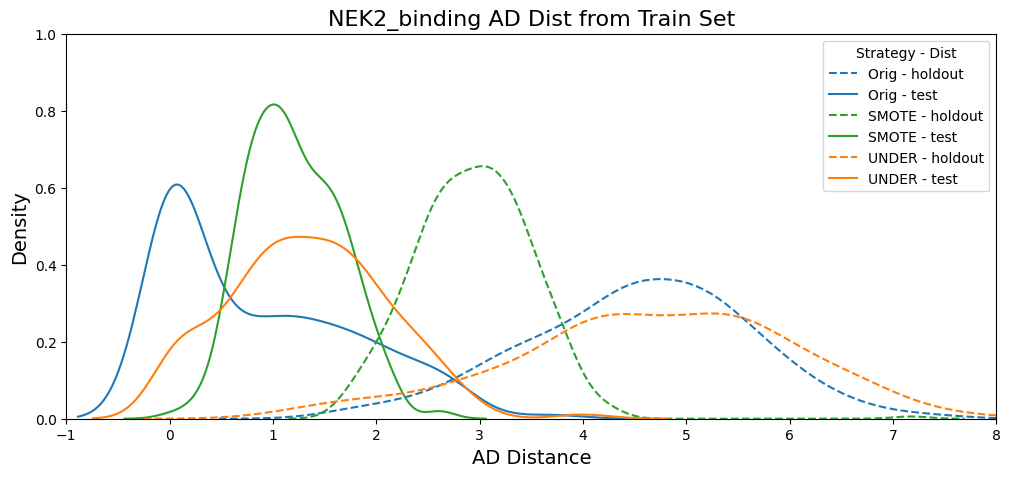

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

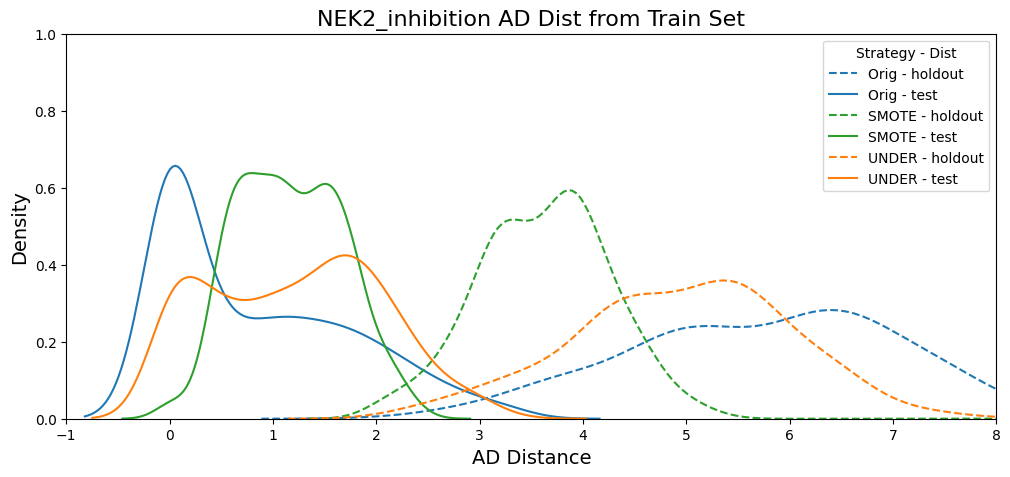

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

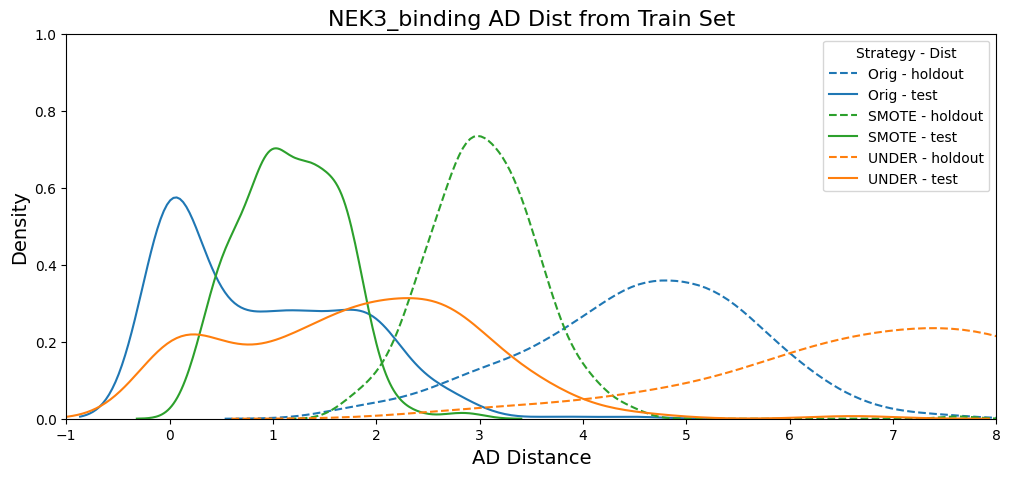

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

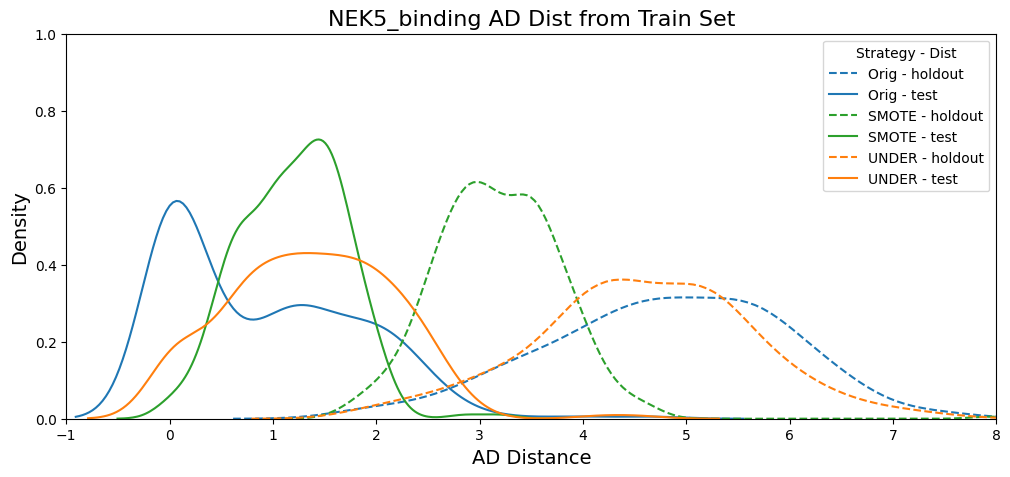

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

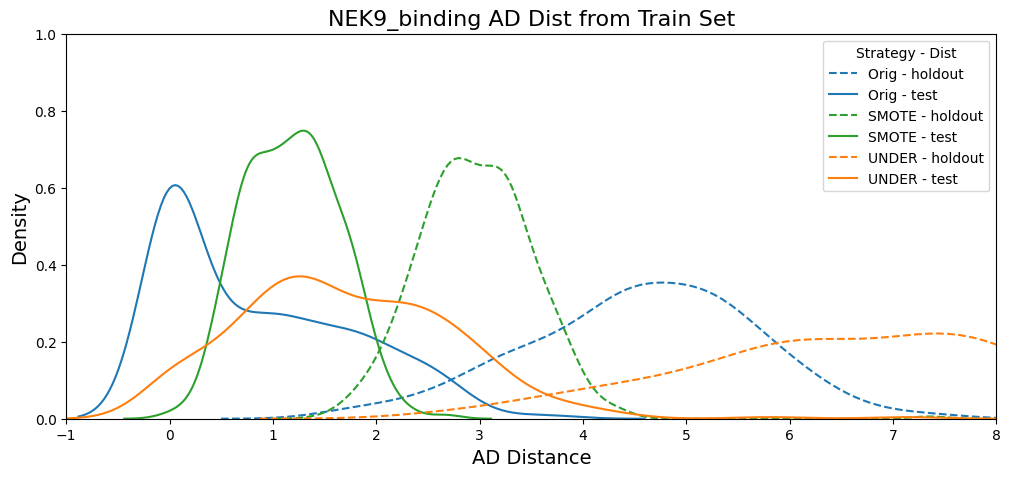

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

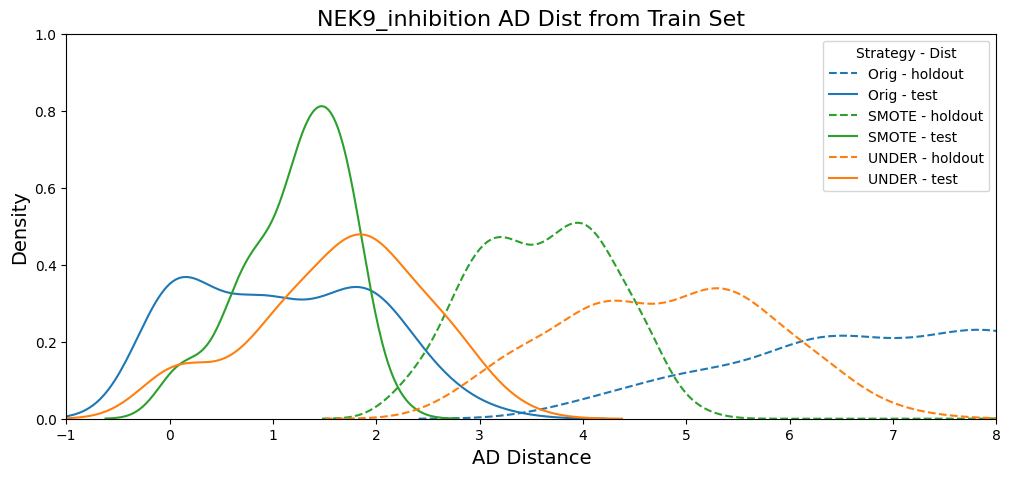

In [85]:
ls_map = {'test':'-', 'holdout':'--' }
for nek in neks: 
    df = all_AD_dists[all_AD_dists['NEK']==nek]
    df_flat = df.explode('ADdist').copy()

    df_flat['ADdist'] = pd.to_numeric(df_flat['ADdist'])
    fig, ax = plt.subplots(figsize=(12, 5))
    for strategy, df_s in df_flat.groupby('strategy'):
        for dist, df_sd in df_s.groupby('dist'):
            sns.kdeplot(data=df_sd,x='ADdist',ax=ax,
                color=sns.color_palette()[list(df_flat['strategy'].unique()).index(strategy)],
                linestyle=ls_map[dist],label=f'{strategy} - {dist}')

    ax.set_title(f'{nek} AD Dist from Train Set', fontsize=16)
    ax.set_xlabel('AD Distance', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_xlim(-1, 8)
    ax.set_ylim(0,1)

    ax.legend(title="Strategy - Dist")
    plt.show()

In [101]:
# method to translate ecfp fingerprints in DF back to bitvectors
from rdkit.DataStructs import ExplicitBitVect
def df_to_bitvect(df):
    bitvects = []
    for _, row in df.iterrows():
        bit_string = ''.join(row.astype(str))
        bitvect = ExplicitBitVect(len(bit_string))
        for i, bit in enumerate(bit_string):
            if bit == '1':
                bitvect.SetBit(i)
        bitvects.append(bitvect)
    return bitvects
    

In [2]:
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import getpass
from atomsci.ddm.pipeline import chem_diversity as cd
from atomsci.ddm.pipeline import dist_metrics
import logging
import matplotlib.pyplot as plt


In [3]:
def get_tani_dist_distr(df, smiles_col, radius=2, subset_col='subset', subsets=True, 
                         ref_subset='test'):
    num_cmpds = len(df)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    calc_type='nearest'
    num_nearest=1
    dists=pd.DataFrame([], columns=['dist','subset'])
    for subs in df[subset_col].unique():
        if subs==ref_subset:
            continue
        smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values 
        smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
        fprints1_df=df.loc[df['subset']==ref_subset, [col for col in df.columns if 'ecfp' in col]]
        fprints2_df=df.loc[df['subset']==subs, [col for col in df.columns if 'ecfp' in col]]
        
        fprints1=df_to_bitvect(fprints1_df)
        fprints2=df_to_bitvect(fprints2_df)
        
        
        within_dset=False
        diststmp=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
                
        # diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type='nearest', num_nearest=1)

        # diststmp = diststmp.flatten()
        substmp=[subs]*len(diststmp)
        diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist','subset'])
        dists=pd.concat([dists,diststmp])
    dists=dists.reset_index(drop=True)
    return dists

In [ ]:
colors = ["#6EC8BE","#BE2369","#FFC30F","#694691","#EB1E23","#7682A4","#373C50","#A7DDD8",]
sns.set_palette(sns.color_palette(colors))
def plot_corr_matrices_ecfp_traintest(dfs, dflabs,
                    firstcols = "ecfp_2048_0", 
                    lastcols = "ecfp_2048_2047", 
                    rowlabelcols = 'subset',
                    collabelcols='active',
                    dataset_names = ['train vs. test']):
    '''
    pass in a list of dataframes with associated labels, the columns to subset on for computing the UMAP, and which columns should reflect the labels and values
    computes umap and returns a strip of UMAP plots using each item in each list
    '''
    corr_dfs=[]
    figs = []
    for i, df in enumerate(dfs):
        print("Computing correlation matrix for", dflabs[i])
        # df=df.set_index([rowlabelcols[i]])
        # map_df = df.loc[:,firstcols[i]:lastcols[i]]
        df = df.set_index(rowlabelcols)
        map_df = df.loc[:, firstcols:lastcols]
        
        corr_matrix = pd.DataFrame(squareform(pdist(map_df, metric='jaccard')), columns=map_df.index, index=map_df.index)
        corr_matrix.columns = df[collabelcols] 
        unique_rows = df.index.unique()
        unique_cols = df[collabelcols].unique()
        lut = dict(zip(unique_rows, colors[:len(unique_rows)])) # train and test colors 
        lut2 = dict(zip(unique_cols, colors[-len(unique_cols):]))  # active inactive backwards
        row_colors = df.index.map(lut)
        col_colors = df[collabelcols].map(lut2)
        
        # lut = dict(zip(df.index.unique(), colors))
        # lut2=dict(zip(df[collabelcols.unique(), colors[-df[collabelcols].nunique():]))
        # row_colors = map_df.index.map(lut)
        # col_colors = df[collabelcols].map(lut2)
        
        g=sns.clustermap(corr_matrix, row_colors=row_colors, col_colors=col_colors)
        g.fig.suptitle(f"{dflabs[i]} correlation matrix of {dataset_names[i]}", y=1.02)
        # g.savefig(f'{corr_plots}{dflabs[i]}.png')
        corr_dfs.append(corr_matrix)
        
        figs.append(g.fig)
     
    return corr_dfs, figs